# Data preparation for Large Language Model.

I will discuss the high level concept of Data preparation steps for LLM. The context is from the book "Large Language Model From Scratch" by Sebastian Raschka. 
The figure shows the LLM data preparation pipeline. 

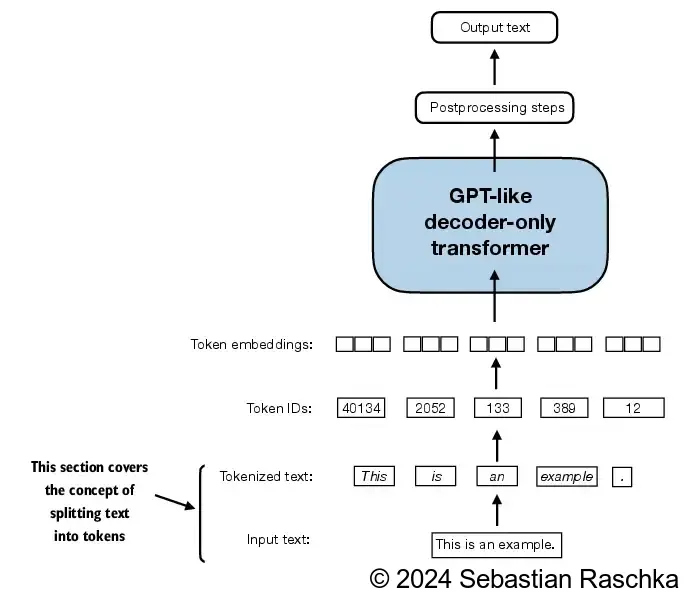

### 1. Tokenizer 

In [1]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

'the-verdict.txt' book will be used as the text data source for this example. We need to load the data first.

In [2]:
with open("the-verdict.txt", "r") as f:
    texts = f.read()
print(texts[:50])

I HAD always thought Jack Gisburn rather a cheap g


Let us see how gpt2 tokenizer converts the texts into token ids using .encode function call.

In [3]:
# encoding creates token ids
token_ids50 = tokenizer.encode(texts[:50])
print(token_ids50)

[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 308]


Let's now see the token ids and corresponding words encoded by gpt2 tokenizer. The .decode function call convert each token ids into corresponding words or subwords.

In [4]:
# decoding retrives corresponding words or subwords from token ids
tokens50 = tokenizer.decode(token_ids50)
print(tokens50)

I HAD always thought Jack Gisburn rather a cheap g


In [5]:
for token_id in token_ids50:
    token = tokenizer.decode([token_id])
    print(token,'----->',token_id)

I -----> 40
 H -----> 367
AD -----> 2885
 always -----> 1464
 thought -----> 1807
 Jack -----> 3619
 G -----> 402
is -----> 271
burn -----> 10899
 rather -----> 2138
 a -----> 257
 cheap -----> 7026
 g -----> 308


From the above we can see how tokenization works. It is worth to mention that these tokenization process also capture the trailing or begining space of any tokens. 

### 2. A Dataset and Dataloader

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

In [7]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)    #1

        for i in range(0, len(token_ids) - max_length, stride):     #2
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):    #3
        return len(self.input_ids)

    def __getitem__(self, idx):         #4
        return self.input_ids[idx], self.target_ids[idx]


# max_length = number of token_ids consider for sliding windows
# stride = shifting of number of token_ids
# for example, stride=1, [tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
print(torch.cuda.is_available())

True


In [8]:
def create_dataloader_v1(txt, batch_size=2, max_length=256,
                         stride=256, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")                         #1
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)   #2
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,     #3
        num_workers=num_workers     #4
    )

    return dataloader

Let's see the first and second input:target pairs of our data. 

In [9]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

max_length = 6

dataloader = create_dataloader_v1(
    raw_text, batch_size = 1, max_length = max_length, stride = max_length, 
    shuffle = False)
data_iter = iter(dataloader)      #1
first_batch = next(data_iter)
print('input:',first_batch[0],"\n",'target:', first_batch[-1])

input: tensor([[  40,  367, 2885, 1464, 1807, 3619]]) 
 target: tensor([[ 367, 2885, 1464, 1807, 3619,  402]])


In [10]:
second_batch = next(data_iter)
print('input:',second_batch[0],"\n",'target:',second_batch[-1])

input: tensor([[  402,   271, 10899,  2138,   257,  7026]]) 
 target: tensor([[  271, 10899,  2138,   257,  7026, 15632]])


The inputs and targets are converted into 2-Dimensional vectors with 1 row and max_length columns. 

In [11]:
second_batch[0].shape

torch.Size([1, 6])

### 3. Token Embedding

In [12]:
# embedding is like a Look-Up table
vocab_size = 50257
output_dim = 256

torch.manual_seed(123)
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [13]:
print(token_embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035,  ...,  1.3337,  0.0771, -0.0522],
        [ 0.2386,  0.1411, -1.3354,  ..., -0.0315, -1.0640,  0.9417],
        [-1.3152, -0.0677, -0.1350,  ..., -0.3181, -1.3936,  0.5226],
        ...,
        [ 0.5871, -0.0572, -1.1628,  ..., -0.6887, -0.7364,  0.4479],
        [ 0.4438,  0.7411,  1.1263,  ...,  1.2091,  0.6781,  0.3331],
        [-0.2537,  0.1446,  0.7203,  ..., -0.2134,  0.2144,  0.3006]],
       requires_grad=True)


In [14]:
torch.manual_seed(123)
# Get embedding for token index 0
first_em = token_embedding_layer(torch.tensor([1]))
# Turn off scientific notation
torch.set_printoptions(sci_mode=False)
# Print the tensor
print(first_em)

tensor([[ 0.2386,  0.1411, -1.3354, -2.9340,  0.1141, -1.2072, -0.3008,  0.1427,
         -1.3027, -0.4919, -2.1429,  0.9488, -0.5684, -0.0646,  0.6647, -2.7836,
          1.1366,  0.9089,  0.9494,  0.0266, -0.9221,  0.7034, -0.3659, -0.1965,
         -0.9207,  0.3154, -0.0217,  0.3441,  0.2271, -0.4597, -0.6183,  0.2461,
         -0.4055, -0.8368,  1.2277, -0.4297, -2.2121, -0.3780,  0.9838, -1.0895,
          0.2017,  0.0221, -1.7753, -0.7490,  0.2781, -0.9621, -0.4223, -1.1036,
          0.2473,  1.4549, -0.2835, -0.3767, -0.0306, -0.0894, -0.1965, -0.9713,
          0.9005, -0.2523,  1.0669, -0.2985,  0.8558,  1.6098, -1.1893,  1.1677,
          0.3277, -0.8331, -1.6179,  0.2265, -0.4382,  0.3265, -1.5786, -1.3995,
          0.5446, -0.0830, -1.1753,  1.7825,  1.7524, -0.2135,  0.4095,  0.0465,
          0.6367, -0.1943, -0.8614,  0.5338,  0.9376, -0.9225,  0.7047, -0.2722,
          0.0144, -0.6411,  2.3902, -1.4256, -0.4619, -1.5539, -0.3338,  0.2405,
          2.1065,  0.5509, -

### 4. Position Embedding

In [15]:
max_length = 1024
context_length = max_length

torch.manual_seed(123)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

### 5. Input Embedding

In [16]:
batch_size = 2

dataloader = create_dataloader_v1(
    raw_text,
    batch_size=batch_size,
    max_length=max_length,
    stride=max_length
)

In [17]:
for batch in dataloader:
    x, y = batch

    token_embeddings = token_embedding_layer(x)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))

    input_embeddings = token_embeddings + pos_embeddings

    break

In [18]:
input_embeddings.shape

torch.Size([2, 1024, 256])